Notebook for i259 final project

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from bs4 import BeautifulSoup 
import requests
import urllib3
from datetime import datetime as dt
import pandas as pd
import json

In [26]:
def get_html_rows(url):
    r = requests.get(url, verify=False) 
    s = BeautifulSoup(r.content, 'html5lib') 
    html = s.prettify()
    return html.splitlines()

,TITLE,REGION,DISTANCE,DIST_TYPE,GAIN,HIGHEST,RATING,RATING_COUNT,LATITUDE,LONGITUDE,REPORT_DATE,REPORT_COUNT,URL
0,2773' 353'P,Central Cascades,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,2011-01-18,1,https://www.wta.org/go-hiking/hikes/2773-353p
1,360 Trails,Puget Sound and Islands,NaN,NaN,NaN,NaN,0.0,0,47.389053,-122.683876,NaN,0,https://www.wta.org/go-hiking/hikes/360-trails
2,45 Mile Sheep Drive,Central Cascades,4.9,one-way,NaN,3144.0,4.0,5,48.024502,-120.650212,2008-08-09,4,https://www.wta.org/go-hiking/hikes/45-mile-sh...
3,520 Trail,Puget Sound and Islands,4.9,one-way,164.0,164.0,2.5,2,47.645136,-122.301863,2020-08-14,12,https://www.wta.org/go-hiking/hikes/520-trail
4,76 Creek,North Cascades,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,2020-09-21,7,https://www.wta.org/go-hiking/hikes/76-creek-t...


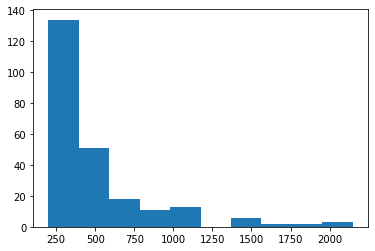

In [32]:
#load data

#originaldata
df = pd.read_csv("/Users/emilygrabowski/Desktop/i259-final/2021-03-29_wta_hike_data.csv")
df.sort_values(by="REPORT_COUNT",ascending=False).index[:99]
plt.hist(df["REPORT_COUNT"].loc[df["REPORT_COUNT"]>200])
top100=df.iloc[df.sort_values(by="REPORT_COUNT",ascending=False).index[:99],:]
df.head()

In [285]:
reports=pd.read_csv("tripreports.csv")
reports["Issues"].unique()
reports["nchar"] = reports["Text"].str.split().str.len()

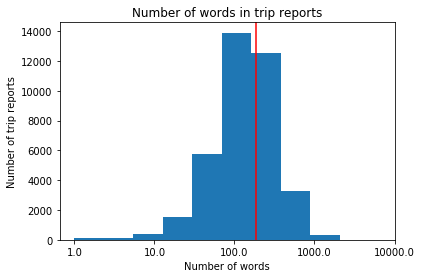

In [287]:
fig=plt.figure()
plt.hist(np.log(reports["nchar"]))
xt = np.log([1,10,100,1000,10000])
xl = [str(round(np.exp(x))) for x in xt]
plt.xticks(xt,xl)
plt.title("Number of words in trip reports")
plt.xlabel("Number of words")
plt.ylabel("Number of trip reports")
plt.axvline(np.log(np.mean(reports["nchar"])),color ='r')
fig.savefig('words.png', bbox_inches='tight',dpi=150)

In [54]:
reports["Date"]=pd.to_datetime(reports["Date"])
reports["Date"].dt.year
reports["Date"].dt.month
reports["Text"] = reports["Text"].str.encode(encoding='ascii', errors='ignore').str.decode(encoding = 'ascii').str.lower()

0         9
1         8
2         8
3         8
4         8
         ..
39595    12
39596    12
39597    12
39598    12
39599    12
Name: Date, Length: 39600, dtype: int64

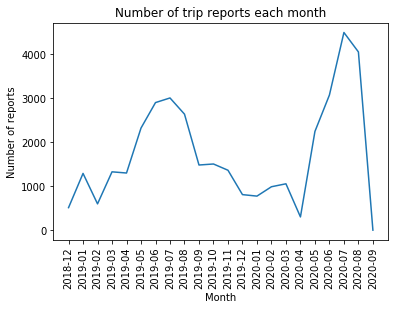

In [281]:
fig = plt.figure()
plt.plot(reports["Date"].dt.strftime('%Y-%m').value_counts().sort_index())
ax=plt.gca()
ax.set_xticklabels(labels = reports["Date"].dt.strftime('%Y-%m').value_counts().sort_index().index,rotation=90)
plt.title("Number of trip reports each month")
plt.xlabel("Month")
plt.ylabel("Number of reports")
fig.savefig('dates.png', bbox_inches='tight',dpi=150)

In [90]:
print("There are",len(reports.index),"trip reports in the dataset")
print("The earliest trip report is",min(reports["Date"]), "and the latest report is",max(reports["Date"]))
print("The number of hikes",reports["Hike Name"].nunique())

print("The percentage of hikes with more than 1 trip reports",len(reports["Hike Name"].value_counts().sort_values()[reports["Hike Name"].value_counts().sort_values()>5]))
reports["Hike Name"].value_counts().sort_values()[reports["Hike Name"].value_counts().sort_values()>100]

There are 39600 trip reports in the dataset
The earliest trip report is 2018-12-15 00:00:00 and the latest report is 2020-09-01 00:00:00
The number of hikes 6031
The percentage of hikes with more than 1 trip reports 1101


Iron Bear - Teanaway Ridge     101
Grand Park via Lake Eleanor    102
Heliotrope Ridge               103
Skyline Trail Loop             103
Lord Hill Regional Park        104
                              ... 
Mount Si                       298
Rattlesnake Ledge              318
Annette Lake                   326
Lake 22                        328
Lake Serene                    337
Name: Hike Name, Length: 63, dtype: int64

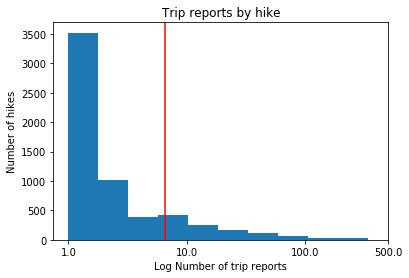

In [323]:

fig = plt.figure()
plt.hist(np.log(reports["Hike Name"].value_counts()).sort_index())
ax=plt.gca()
xt = np.log([1,10,100,500])
xl = [str(round(np.exp(x))) for x in xt]
plt.xticks(xt,xl)
#ax.set_xticklabels(labels = reports["Date"].dt.strftime('%Y-%m').value_counts().sort_index().index,rotation=90)
plt.title("Trip reports by hike")
plt.xlabel("Log Number of trip reports")
plt.ylabel("Number of hikes")
plt.axvline(np.log(np.mean(reports["Hike Name"].value_counts())),color ='r')
fig.savefig('hikes.png', bbox_inches='tight',dpi=150)

In [105]:
def clean_page(html, pretty_print=False):
    from lxml.html import fromstring
    from lxml.html import tostring
    return tostring(fromstring(html), pretty_print=pretty_print)

In [175]:
#clean text for bow

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim import corpora, models
from pprint import pprint
from gensim.parsing.preprocessing import STOPWORDS
import string
import re

def preprocess_text_bow(text):
    stemmer = SnowballStemmer(language='english')
    tokens = [t for t in word_tokenize(text) if not t in STOPWORDS]
    tokens = [WordNetLemmatizer().lemmatize(x) for x in tokens]
    return(tokens)
reports["Text"] = reports["Text"].str.replace(r'[^\w\s]','')
reports = reports.dropna(subset=["Text"])
bow = []
for t in reports["Text"]:

    bow.append(preprocess_text_bow(t))



In [300]:
dictionary = corpora.Dictionary(bow)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)
bow_corpus = [dictionary.doc2bow(doc) for doc in bow]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08786020179595769),
 (1, 0.1512071402075179),
 (2, 0.1323808198863417),
 (3, 0.13345706328737827),
 (4, 0.21980530193287132),
 (5, 0.0854003282661759),
 (6, 0.23753770450315975),
 (7, 0.2036601254955504),
 (8, 0.16119766272083524),
 (9, 0.1925509440580139),
 (10, 0.2683510143375814),
 (11, 0.056186799304374695),
 (12, 0.18408676107396071),
 (13, 0.0818699367918405),
 (14, 0.1623530762937038),
 (15, 0.22976044468078483),
 (16, 0.06431763946857423),
 (17, 0.12324152521614407),
 (18, 0.1137399064911942),
 (19, 0.14225128518426763),
 (20, 0.13227240903405063),
 (21, 0.08943786423906225),
 (22, 0.2079803314774219),
 (23, 0.21102433116220254),
 (24, 0.10763670616903104),
 (25, 0.2217528383728915),
 (26, 0.13608702650356613),
 (27, 0.10645130411425052),
 (28, 0.22710436851471769),
 (29, 0.08242759746404216),
 (30, 0.316149604850709),
 (31, 0.07345134520852238),
 (32, 0.055830909847418154),
 (33, 0.08125502486027394),
 (34, 0.1149547856310533),
 (35, 0.13046766716208044),
 (36, 0.250080

In [324]:
lda_model = models.LdaMulticore(bow_corpus, num_topics=100, id2word=dictionary, passes=2, workers=2)

In [288]:
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=100, id2word=dictionary, passes=2, workers=4)

In [303]:
for index, score in sorted(lda_model_tfidf[bow_corpus[6]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

IndexError: index 65 is out of bounds for axis 0 with size 25

In [325]:
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
def format_topics_sentences(ldamodel=None, corpus = None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=reports["Text"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.4889,"people, like, bug, got, saw, dont, pretty, goi...",I drove from Wenatchee it only took about 30 m...
1,1,64.0,0.7031,"little, bay, spot, people, compacted, plenty, ...",Arrived around 8:30am on sat morning and park ...
2,2,67.0,0.8142,"park, picnic, goose, tunnel, area, table, walk...",Nice short leg stretcher hike with peak views....
3,3,33.0,0.9100,"beautiful, easy, olallie, nice, talapus, littl...",This grail was perfect for small children! We ...
4,4,44.0,0.5430,"wildflower, flower, meadow, mountain, ridge, p...","The road is rough, as everyone says. but high ..."
5,5,44.0,0.4006,"wildflower, flower, meadow, mountain, ridge, p...",A wildflower update for Berkeley Park. Bog gen...
6,6,45.0,0.3698,"december, pond, excelsior, tree, harrys, peggy...",We planned to do this hike but could not make ...
7,7,13.0,0.4035,"groomed, took, got, 2, monte, cristo, old, win...","Beautiful views! Once you get to the lake, you..."
8,8,72.0,0.3065,"area, tree, chain, beautiful, easy, bit, paved...",The trail was in good condition; there were so...
9,9,32.0,0.4391,"spike, pole, micro, recommend, hiking, boot, h...",Great hike. Picked up hat and sunglasses left ...


In [326]:
def first(x):
    return(x.iloc[0])
sub = df_dominant_topic.groupby(by="Dominant_Topic").agg(func = first)
for index,row in sub.iterrows():
    print(index,row['Keywords'])

0.0 car, trailhead, got, group, hour, arrived, hiking, people, shoe, didnt
1.0 ridge, section, pas, mountain, gt, steep, route, peak, pct, north
2.0 ice, ridge, mountain, slope, tree, summit, microspikes, steep, foot, creek
3.0 area, coal, park, little, town, loop, trailhead, red, today, paved
4.0 beach, tide, park, sand, bluff, walk, low, state, point, island
5.0 people, like, bug, got, saw, dont, pretty, going, bad, didnt
6.0 canyon, highway, ridge, north, wall, bend, fall, mountain, old, y
7.0 duck, eagle, saw, area, sound, pup, wildlife, easy, wood, bald
8.0 knob, sunshine, burned, noble, 410, search, 2018, dalles, urban, greenwater
9.0 si, new, teneriffe, mount, moss, summit, little, old, mt, loop
10.0 saw, hiker, flower, trailhead, arrived, wildflower, car, mountain, group, easy
11.0 trailhead, bit, car, park, pretty, grand, right, crust, good, going
12.0 goat, pct, mountain, snowy, basin, snowgrass, kendall, foot, old, commonwealth
13.0 groomed, took, got, 2, monte, cristo, old,

In [327]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document
print(df_dominant_topic.shape,reports.shape)
#pd.merge(reports,df,on = "")

(39600, 5) (39600, 10)


In [330]:
topics= np.zeros([int(len(bow_corpus)),100])
#print(topics.shape)
for k in range(len(bow_corpus)):
    for topic, prob in lda_model[bow_corpus[k]]:
        topics[k,topic]=prob
        #print(topics[k])
        
reps = pd.concat([reports,pd.DataFrame(topics)],axis=1)
reps.shape

(39600, 110)

In [331]:
reps.head()
data = pd.merge(reps,df,how='left',right_on="TITLE",left_on="Hike Name")
print(data.shape)
print(list(data))
data.head()



(41675, 123)
['Unnamed: 0', 'Hike Name', 'User', 'Text', 'Date', 'URL_x', 'Region', 'Issues', 'Upvotes', 'nchar', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 'TITLE', 'REGION', 'DISTANCE', 'DIST_TYPE', 'GAIN', 'HIGHEST', 'RATING', 'RATING_COUNT', 'LATITUDE', 'LONGITUDE', 'REPORT_DATE', 'REPORT_COUNT', 'URL_y']


,Unnamed: 0,Hike Name,User,Text,Date,URL_x,Region,Issues,Upvotes,nchar,...,DIST_TYPE,GAIN,HIGHEST,RATING,RATING_COUNT,LATITUDE,LONGITUDE,REPORT_DATE,REPORT_COUNT,URL_y
0,0,Ingalls Creek,L. Mccy,I drove from Wenatchee it only took about 30 m...,"Sep 01, 2020","""https://www.wta.org/go-hiking/trip-reports/tr...",Central Cascades -- Blewett Pass,NaN,1.0,111.0,...,one-way,1450.0,3450.0,3.62,29.0,47.462833,-120.673217,2021-01-17,411.0,https://www.wta.org/go-hiking/hikes/ingalls-creek
1,1,Talapus and Olallie Lakes,larizinga,Arrived around 8:30am on sat morning and park ...,"Aug 31, 2020","""https://www.wta.org/go-hiking/trip-reports/tr...",Snoqualmie Region -- Snoqualmie Pass,road conditions,3.0,37.0,...,roundtrip,1220.0,3780.0,3.92,109.0,47.401254,-121.518359,2021-03-26,1497.0,https://www.wta.org/go-hiking/hikes/talapus-an...
2,2,Washington Pass Overlook,cloudmistress,Nice short leg stretcher hike with peak views....,"Aug 31, 2020","""https://www.wta.org/go-hiking/trip-reports/tr...",North Cascades -- North Cascades Highway - Hwy 20,bugs,1.0,54.0,...,roundtrip,61.0,5581.0,3.50,10.0,48.524538,-120.658134,2020-10-17,57.0,https://www.wta.org/go-hiking/hikes/washington...
3,3,Franklin Falls,Susan Black,This grail was perfect for small children! We ...,"Aug 31, 2020","""https://www.wta.org/go-hiking/trip-reports/tr...",Snoqualmie Region -- Snoqualmie Pass,NaN,1.0,34.0,...,roundtrip,400.0,2600.0,4.11,99.0,47.413108,-121.442769,2021-03-18,1120.0,https://www.wta.org/go-hiking/hikes/franklin-f...
4,4,Bear Creek Mountain,CascadeScrambler,"The road is rough, as everyone says. but high ...","Aug 31, 2020","""https://www.wta.org/go-hiking/trip-reports/tr...",South Cascades -- Goat Rocks,road conditions,7.0,183.0,...,roundtrip,1237.0,7337.0,3.50,10.0,46.538102,-121.316214,2020-10-03,59.0,https://www.wta.org/go-hiking/hikes/bear-creek...


In [439]:
#ix = data.groupby(by="Hike Name")[84].mean().index[data.groupby(by="Hike Name")[84].mean().values>0.1]
#print(sum(data.groupby(by="Hike Name")[84].mean().values>0.1))
#data.loc[data["Hike Name"].isin(ix),"Hike Name"].nunique()



trash = data.loc[data[84]>.5]
print(trash['Text'].str.contains("trash"))
trash.loc[6882,'Text']
#plt.hist(trash["Month"])




764      False
2694     False
2842     False
3589     False
3629     False
3724     False
3976     False
5156     False
6882      True
7328     False
7408     False
7660     False
9020     False
9021     False
9040     False
9360     False
9470     False
11217    False
11475    False
11770    False
11959    False
13106    False
13539    False
14504    False
14506    False
14825    False
17607    False
18724    False
19077    False
22408    False
26040    False
26400    False
27949    False
29018    False
29237    False
29257    False
30412    False
31596    False
31741     True
31872    False
32028    False
35144    False
36413    False
38280    False
Name: Text, dtype: bool


"At the trailhead at 08:40 on a Wednesday, and already there were maybe 20 cars in the lot.Â\xa0 It's a big lot, but still that's a lot of people.Â\xa0 Fortunately, they were all nice people.The road has a lot of potholes.Â\xa0 It's not too bad if you take it really slowly.The trailhead toilet and trash bin were open!Not a lot of flowers on this trail, but there were some very nice patches, with foxglove just reaching its peak in the open areas.One complaint:Â\xa0 Several people left bags of dog poop by the side of the trail.Â\xa0 Sincerely hope they retrieved them on their way out."

In [374]:
#reports label
print("The number of reports labelled with  hazards are:" ,sum(data['Issues'].isnull()))
print(data["Issues"].unique())
data['Road'] = data["Issues"].str.contains('road')
data['Trail'] = data["Issues"].str.contains('trail')
print("The number of reports labelled with trail hazards are:" ,np.nansum(data['Trail']))
#("The number of reports labelled with road hazards are:" ,np.nansum(data['Road']))
print(data['Trail'].unique())

The number of reports labelled with  hazards are: 19229
[nan 'road conditions' 'bugs' 'trail conditions'
 'bugs, road &amp; trail conditions' 'road, trail conditions'
 'road, snow conditions' 'bugs, road conditions' 'bugs, trail conditions'
 'snow conditions' 'road, snow &amp; trail conditions'
 'bugs, road &amp; snow conditions'
 'bugs, road, snow &amp; trail conditions' 'snow, trail conditions'
 'bugs, snow conditions' 'bugs, snow &amp; trail conditions']
The number of reports labelled with trail hazards are: 12359
[nan False True]


In [372]:
12/39

0.3076923076923077

In [382]:
from sklearn.svm import SVC
data=data.dropna()
model = SVC(kernel='linear')
print(list(data))
y = data["Trail"].astype(int)
X = np.array(data.iloc[:,10:110])
#print(sum(X.isnull()))
model.fit(X,y)
model.score(X,y)

['Unnamed: 0', 'Hike Name', 'User', 'Text', 'Date', 'URL_x', 'Region', 'Issues', 'Upvotes', 'nchar', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 'TITLE', 'REGION', 'DISTANCE', 'DIST_TYPE', 'GAIN', 'HIGHEST', 'RATING', 'RATING_COUNT', 'LATITUDE', 'LONGITUDE', 'REPORT_DATE', 'REPORT_COUNT', 'URL_y', 'Road', 'Trail']


0.5455018200728029

[0.02979972]
78


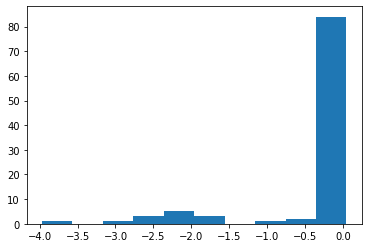

In [399]:
#model.score(X,y)
model.coef_.shape
print(model.coef_.T[84])
plt.hist(model.coef_.T)
print(np.argmax(model.coef_))

In [380]:
from sklearn.svm import SVC
data=data.dropna()
model = SVC(kernel='linear')
print(list(data))
y = data["Trail"].astype(int)
X = np.array(data.iloc[:,94])
#print(sum(X.isnull()))
model.fit(X,y)
model.score(X,y)

['Unnamed: 0', 'Hike Name', 'User', 'Text', 'Date', 'URL_x', 'Region', 'Issues', 'Upvotes', 'nchar', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 'TITLE', 'REGION', 'DISTANCE', 'DIST_TYPE', 'GAIN', 'HIGHEST', 'RATING', 'RATING_COUNT', 'LATITUDE', 'LONGITUDE', 'REPORT_DATE', 'REPORT_COUNT', 'URL_y', 'Road', 'Trail']


KeyboardInterrupt: 